# Instructions
## Getting the Datasets
* Request access to and download the AffectNet Dataset

## Organize Datasets
* Follow README instructions in Face Wizard github repo to organize the dataset

## Setup Google Drive
* Import zipped version of the organized datasets to google drive

## Build Datasets
* Build the dataset according the desired dataset (orginal or cropped)

# Import Dependencies

In [0]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import History
from keras.models import model_from_json
from keras.models import load_model

from google.colab import files
from google.colab import drive

from pathlib import Path
import timeit
import cv2
import os
import shutil
import random
import zipfile
import json

Using TensorFlow backend.


# Mount Google Drive Locally

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Build Affectnet Dataset

In [0]:
def build_dataset(data_file):
  emotion_hash = {"anger":[], "contempt":[], "disgust":[], "fear":[], "happiness":[],
                 "neutral":[], "no-face":[], "none": [], "sadness":[], "surprise":[], "uncertain":[]}

  zip_file = zipfile.ZipFile(data_file)
  
  for file_name in zip_file.namelist():
    file_name_split = file_name.split('/')
#     print(file_name_split)
    if file_name_split[0] in emotion_hash.keys():
      if "{}/".format(file_name_split[0]) != file_name:
        emotion_hash[file_name_split[0]].append(file_name)

        
  # Check if training_set folder already exists
  # if it already exists, remove all contents and the folder itself
  if os.path.exists("affectnet_training_set"):
    emotion_list = os.listdir("affectnet_training_set")
    for emotion in emotion_list:
      sub = os.path.join("affectnet_training_set", emotion)
      for img in os.listdir(sub):
        if (".ipynb" in img):
          print(img)
          os.rmdir(os.path.join(sub,img))
        if os.stat(os.path.join(sub,img)).st_size == 0:
          print(img)
          continue
        os.remove(os.path.join(sub, img))
      os.removedirs(sub)
    
      
  if os.path.exists("affectnet_testing_set"):
    emotion_list = os.listdir("affectnet_testing_set")
    for emotion in emotion_list:
      sub = os.path.join("affectnet_testing_set", emotion)
      for img in os.listdir(sub):
        if (".ipynb" in img):
          print(img)
          os.rmdir(os.path.join(sub,img))
        if os.stat(os.path.join(sub,img)).st_size == 0:
          print(img)
          continue
        os.remove(os.path.join(sub, img))
      os.removedirs(sub)
      
  # Create training and testing directories
  os.mkdir("affectnet_training_set")
  os.mkdir("affectnet_testing_set")
  
  # Shuffle files and create training and testing sets
  for emotion in emotion_hash.keys():
    training_size = int(.8*len(emotion_hash[emotion]))
    random.shuffle(emotion_hash[emotion])
    i = 0
    while i < training_size:
      zip_file.extract(emotion_hash[emotion][i], "affectnet_training_set")
      i += 1
    while i < len(emotion_hash[emotion]):
      zip_file.extract(emotion_hash[emotion][i], "affectnet_testing_set")
      i += 1

In [0]:
build_dataset("/content/gdrive/My Drive/affectnet_22k.zip")

# Resize All Images

In [0]:
def resize_all(dataset):
  emotion_hash = {"anger":[], "contempt":[], "disgust":[], "fear":[], "happiness":[],
                 "neutral":[], "no-face":[], "none": [], "sadness":[], "surprise":[], "uncertain":[]}
  for emotion in emotion_hash.keys():
    emotion_path = os.path.join(dataset, emotion)
    emotion_imgs = os.listdir(emotion_path)
    for image in emotion_imgs:
      img_path = os.path.join(emotion_path, image)
      img = cv2.imread(img_path)
      img = cv2.resize(img, (128,128))
      cv2.imwrite(img_path, img)
  print("Resizing", dataset, "done.")

In [0]:
resize_all("affectnet_testing_set")

Resizing affectnet_testing_set done.


In [0]:
resize_all("affectnet_training_set")

Resizing affectnet_training_set done.


# Crop Face

In [0]:
# This function detects and crops the face 
def detect_face(path_to_image):
  face_cascade = cv2.CascadeClassifier('/content/gdrive/My Drive/haarcascade_frontalface_default.xml')
  if ".ipynb_checkpoints" not in path_to_image:
    try:
      img = cv2.imread(path_to_image)
      img = cv2.resize(img, (128,128))
#       img = cv2.resize(img, (224,224))
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = gray
      face = face_cascade.detectMultiScale(gray, 1.3, 5)
      for (x,y,w,h) in face:
    #     cv2.rectangle(img, (x,y), (x+w,  y+h), (255,0,0), 2)
        img = img[y:y+h, x:x+w] # This line crops the face from image
        region_of_interest_gray = gray[y:y+h, x:x+w]
        region_of_interest_color = gray[y:y+h, x:x+w]

    #   plt.imshow(img)
      cv2.imwrite(path_to_image, img)
    except Exception as e:
      print("Fucked up image :( ")
      os.remove(path_to_image)

In [0]:
# Test view an image from the dataset
test_img = os.listdir("affectnet_training_set/anger")[0]
img_path = os.path.join("affectnet_training_set/anger", test_img)

detect_face(img_path)


In [0]:
# Crop images from specified dataset
def crop_images(dataset):
  print("Cropping", dataset)
  emotion_hash = {"anger":[], "contempt":[], "disgust":[], "fear":[], "happiness":[],
                 "neutral":[], "no-face":[], "none": [], "sadness":[], "surprise":[], "uncertain":[]}
  for emotion in emotion_hash.keys():
    emotion_path = os.path.join(dataset, emotion)
    emotion_imgs = os.listdir(emotion_path)
    for image in emotion_imgs:
      img_path = os.path.join(emotion_path, image)
#       print("cropping ", img_path)
      detect_face(img_path)
  print("Cropping", dataset, "done.")

In [0]:
crop_images("affectnet_testing_set")

Cropping affectnet_testing_set
Cropping affectnet_testing_set done.


In [0]:
crop_images("affectnet_training_set")

Cropping affectnet_training_set
Cropping affectnet_training_set done.


## View Image

In [0]:
def display_face(path_to_image):
  face_cascade = cv2.CascadeClassifier('/content/gdrive/My Drive/haarcascade_frontalface_default.xml')
  img = cv2.imread(path_to_image)
  plt.imshow(img)

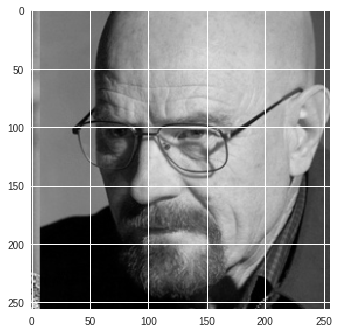

In [0]:
test_img = os.listdir("affectnet_testing_set/anger")[3]
img_path = os.path.join("affectnet_testing_set/anger", test_img)
display_face(img_path)

# Build Model

## Define Model

In [0]:
from keras.applications import ResNet50
from keras.models import Model

def build_model(width, height, depth, classes, finalAct="softmax"):
  # Define pre-trained vgg16 model
  vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(width,height,depth))

  model = Sequential()
  for layer in vgg16.layers[0:11]:
    model.add(layer)
    
  for layer in model.layers:
    layer.trainable = False

  model.add(Conv2D(512, (3, 3), padding="same"))
  model.add(Conv2D(512, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(1024, (3, 3), padding="same"))
  model.add(Conv2D(1024, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(2048, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
    
  model.add(Flatten())
  model.add(Dense(32))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(classes, activation='softmax'))

  
  print("model Summary:")
  model.summary()
    
  opt = Adam(lr=0.001)
    
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model



## Initiate Model

In [0]:
# width = 256
# height = 256
# width = 224
# height = 224

height = 128
width = 128
depth = 3
classes = 11

model_affectnet = build_model(width, height, depth, classes)


# Define Data Augmentors

In [0]:
train_aug = ImageDataGenerator(rescale=1./255,
                              rotation_range=30,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode='nearest')

valid_aug = ImageDataGenerator(rescale=1./255)

# Define Data Batches

In [0]:
train_batch = 106 # 44 steps_per_epoch
valid_batch = 80 # 20 validation_steps


training_path = "affectnet_training_set"
testing_path = "affectnet_testing_set"


train_batches = train_aug.flow_from_directory(training_path,
                                             target_size=(width,height),
                                             batch_size=train_batch,
                                             class_mode='categorical')

valid_batches = valid_aug.flow_from_directory(testing_path,
                                             target_size=(width,height),
                                             batch_size=valid_batch,
                                             class_mode='categorical')




Found 17596 images belonging to 11 classes.
Found 4400 images belonging to 11 classes.


# Train Model

In [0]:
history_crop = History()

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='/content/gdrive/My Drive/best_model.h5', monitor='val_loss', save_best_only=True),
              history_crop]


model_affectnet.fit_generator(train_batches,
                   steps_per_epoch=train_batches.samples//train_batches.batch_size,
#                    steps_per_epoch=5,
                   epochs=50,
                   validation_data=valid_batches,
                   validation_steps=valid_batches.samples//valid_batches.batch_size,
#                    validation_steps=5,
                   verbose=1,
                   callbacks=callbacks)

Epoch 1/50
166/166 [==============================] - 131s 787ms/step - loss: 2.6788 - acc: 0.0967 - val_loss: 2.4178 - val_acc: 0.0939
Epoch 2/50
166/166 [==============================] - 124s 749ms/step - loss: 2.5083 - acc: 0.1147 - val_loss: 2.4890 - val_acc: 0.0950
Epoch 3/50
166/166 [==============================] - 124s 746ms/step - loss: 2.4236 - acc: 0.1349 - val_loss: 2.5154 - val_acc: 0.0977
Epoch 4/50
166/166 [==============================] - 124s 746ms/step - loss: 2.3758 - acc: 0.1428 - val_loss: 2.5941 - val_acc: 0.0911
Epoch 5/50
166/166 [==============================] - 124s 748ms/step - loss: 2.3432 - acc: 0.1516 - val_loss: 2.3380 - val_acc: 0.1341
Epoch 6/50
166/166 [==============================] - 124s 750ms/step - loss: 2.3094 - acc: 0.1602 - val_loss: 2.3312 - val_acc: 0.1616
Epoch 7/50
166/166 [==============================] - 125s 752ms/step - loss: 2.2746 - acc: 0.1802 - val_loss: 2.2516 - val_acc: 0.1941
Epoch 8/50
166/166 [============================

# Plot Accuracy

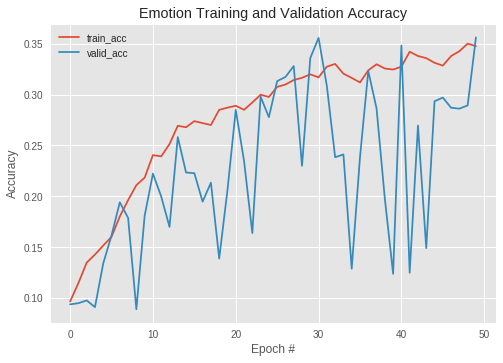

In [0]:
num_epocs = 50

plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, num_epocs), history_crop.history["acc"], label="train_acc")

plt.plot(range(0, num_epocs), history_crop.history["val_acc"], label="valid_acc")

plt.title("Emotion Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()

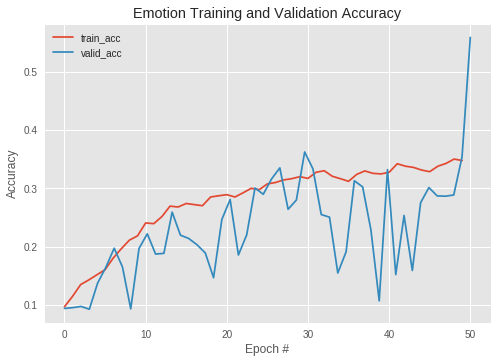

In [0]:
num_epocs = 50

from scipy.interpolate import make_interp_spline, BSpline
val_acc = history_crop.history["val_acc"]
xnew = np.linspace(0, 50, )
smooth_val_acc = make_interp_spline(range(0, 50), val_acc, k=3)
power_smooth = smooth_val_acc(xnew)

plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, num_epocs), history_crop.history["acc"], label="train_acc")

plt.plot(xnew, power_smooth, label="valid_acc")

plt.title("Emotion Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()

# Plot Loss

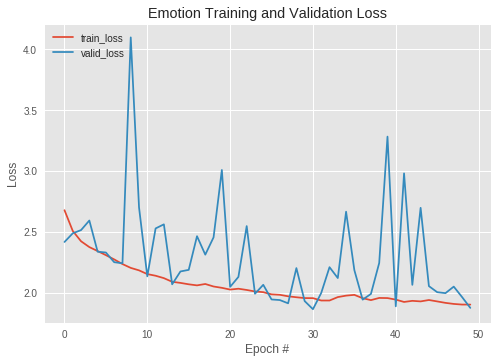

In [0]:
num_epocs = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, num_epocs), history_crop.history["loss"], label="train_loss")
plt.plot(range(0, num_epocs), history_crop.history["val_loss"], label="valid_loss")

plt.title("Emotion Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()

# Plot Feature Maps

In [0]:
def plot_feature_maps(feature_maps):
  height, width, depth = feature_maps.shape
  nb_plot = int(np.rint(np.sqrt(depth)))
  fig = plt.figure(figsize=(30,30))
  for i in range(depth):
    plt.subplot(nb_plot, nb_plot, i+1)
    plt.imshow(feature_maps[:,:,i], cmap='gray')
    plt.title('feature map {}'.format(i+1))
  plt.show()

In [0]:
def plot_layer(model, layer_name, img_path):
  img = crop_face(img_path)
  img = prep_img(img)
  model_crop_layers = [layer.name for layer in model.layers]
  assert layer_name in model_crop_layers
  print(model.input)
  feature_ext = Model(inputs=model.input, outputs=model.get_layer(layer_name).get_output_at(0))
  feature_maps = feature_ext.predict(img)[0]
  print("At layer \"{}\" : {}".format(layer_name, feature_maps.shape))
  plot_feature_maps(feature_maps)

In [0]:
test_path = "ck_crop_testing_set/anger"
testing_imgs = os.listdir(test_path)
img_path = os.path.join(test_path, testing_imgs[0])

plot_layer(model_affectnet, 'block1_conv2', img_path)